In [1]:
pip install attention

In [2]:
import pandas as pd
import numpy as np
from attention import Attention
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:

data = pd.read_csv('/content/Datasets-kathmandu.csv')
scaler = MinMaxScaler(feature_range=(0,1))
num_data_points = len(data)
date_range = pd.date_range(start='2016-01-01', periods=num_data_points, freq='D')
data = data.drop(columns = ['ds'])
data = pd.concat([data, pd.DataFrame({'ds': date_range})], axis=1)

In [5]:
scaled_data = MinMaxScaler(feature_range=(0,1)).fit_transform(data['y'].values.reshape(-1,1))
unscaled_data = MinMaxScaler(feature_range=(0,1)).inverse_transform(scaled_data)
scaled_data

array([[0.28262424],
       [0.2646923 ],
       [0.29196114],
       ...,
       [0.78877635],
       [0.76899347],
       [0.78141847]])

In [6]:
data['ds'] = pd.to_datetime(data['ds'])
train_end_date = '2022-08-01'
test_end_date = '2023-04-28'
train_data = scaled_data[(data['ds'] > '2019-02-01') & (data['ds'] <= test_end_date)]
test_data = scaled_data[(data['ds'] > train_end_date) & (data['ds'] <= test_end_date)]
forecast_data = scaled_data[data['ds'] > test_end_date]

In [7]:
data['ds'] = pd.to_datetime(data['ds'])
filtered_data = data[data['ds'] > '2023-04-28']
filtered_data['y'] += np.random.randint(0, 31, size=len(filtered_data))
data.update(filtered_data)

               y         ds
0     191.231263 2016-01-01
1     183.040896 2016-01-02
2     195.495871 2016-01-03
3     193.733857 2016-01-04
4     193.534451 2016-01-05
...          ...        ...
3343  455.714658 2025-02-25
3344  442.197738 2025-02-26
3345  436.415028 2025-02-27
3346  433.379246 2025-02-28
3347  439.054336 2025-03-01

[3348 rows x 2 columns]


<ipython-input-7-e55b5ad75b06>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['y'] += np.random.randint(0, 31, size=len(filtered_data))


In [8]:
# def create_sequences(data, seq_length):
#     X = []
#     y = []
#     for i in range(len(data) - seq_length):
#         X.append(data[i:i+seq_length])
#         y.append(data[i+seq_length])
#     return np.array(X), np.array(y)

# sequence_length = 80
# X_train, y_train = create_sequences(train_data, sequence_length)
# X_test, y_test = create_sequences(test_data, sequence_length)
# X_forecast, y_forecast = create_sequences(forecast_data, sequence_length)

# # check the shape of the data
# print(X_train.shape)
# print(y_train.shape)
# print(X_test.shape)
# print(y_test.shape)

def create_sequences(data, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(data) - seq_length):
        X_seq.append(data[i:i+seq_length])
        y_seq.append(data[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

sequence_length = 80

X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)
X_forecast, y_forecast = create_sequences(forecast_data, sequence_length)

# Display the shape of the data
shapes = {'X_train': X_train.shape, 'y_train': y_train.shape, 'X_test': X_test.shape, 'y_test': y_test.shape}
for key, value in shapes.items():
    print(f"{key} shape: {value}")


(1467, 80, 1)
(1467, 1)
(190, 80, 1)
(190, 1)


In [ ]:
data['ds'] = pd.to_datetime(data['ds'])

test_end_date = '2023-02-28'

# Split the data based on the defined dates
data = data[data['ds'] <= test_end_date]

In [10]:
inputs = Input(shape=(sequence_length, 1))
lstm_out = (LSTM(128, return_sequences=True))(inputs)
attention_out = Attention(32)(lstm_out)
outputs = Dense(1)(attention_out)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="adam", loss="mean_squared_error")

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

# Train the model with validation
history = model.fit(X_train, y_train, epochs=100, batch_size=80 , validation_data=(X_test, y_test),
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
19/19 [==============================] - ETA: 0s - loss: 0.0468
Epoch 1: val_loss improved from inf to 0.01029, saving model to best_model.h5
19/19 [==============================] - 7s 201ms/step - loss: 0.0468 - val_loss: 0.0103
Epoch 2/100
 1/19 [>.............................] - ETA: 2s - loss: 0.0058

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


19/19 [==============================] - ETA: 0s - loss: 0.0045
Epoch 2: val_loss improved from 0.01029 to 0.00695, saving model to best_model.h5
19/19 [==============================] - 4s 229ms/step - loss: 0.0045 - val_loss: 0.0069
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 0.0030
Epoch 3: val_loss improved from 0.00695 to 0.00438, saving model to best_model.h5
19/19 [==============================] - 5s 271ms/step - loss: 0.0030 - val_loss: 0.0044
Epoch 4/100
19/19 [==============================] - ETA: 0s - loss: 0.0025
Epoch 4: val_loss improved from 0.00438 to 0.00328, saving model to best_model.h5
19/19 [==============================] - 3s 166ms/step - loss: 0.0025 - val_loss: 0.0033
Epoch 5/100
19/19 [==============================] - ETA: 0s - loss: 0.0021
Epoch 5: val_loss improved from 0.00328 to 0.00258, saving model to best_model.h5
19/19 [==============================] - 4s 228ms/step - loss: 0.0021 - val_loss: 0.0026
Epoch 6/100
19/19 [=====

In [ ]:
# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print("Train Loss:", train_loss)
print("Test Loss:", test_loss)

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

6/6 [==============================] - 1s 36ms/step


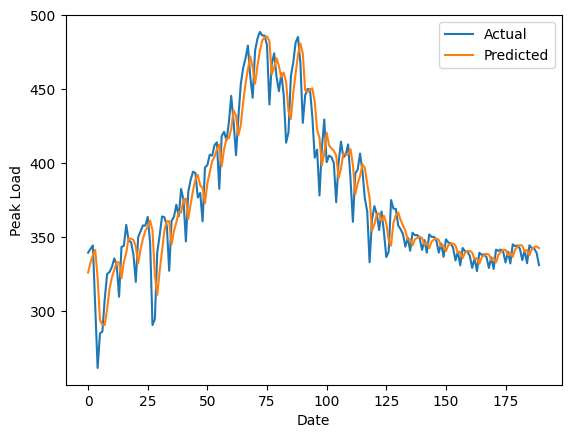

In [14]:
# Load the best model
best_model = Model(inputs=inputs, outputs=outputs)
best_model.load_weights('best_model.h5')

# Test the best model on unseen data
predicted = best_model.predict(X_test)
predicted = scaler.inverse_transform(predicted)
y_test = scaler.inverse_transform(y_test)

# Plot the predicted results and actual values
plt.plot(y_test, label='Actual')
plt.plot(predicted, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Peak Load')
plt.legend()
plt.show()

In [15]:
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

# Making predictions
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
y_test_pred = scaler.inverse_transform(y_test_pred)


6/6 [==============================] - 0s 34ms/step


In [16]:

print(y_test.shape)

(190, 1)


In [17]:
y_test_pred = y_test_pred[:, 0].reshape(-1, 1)
y_train_pred = y_train_pred[:, 0].reshape(-1, 1)
y_test_pred.shape

(190, 1)

In [18]:
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

# Calculate R^2
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)


In [19]:
print("Test MAE:", test_mae)
print("Test MAPE:", test_mape)
print("Test R^2:", test_r2)

Test MAE: 12.303213640946543
Test MAPE: 3.324981269233903
Test R^2: 0.8810947423545816


In [20]:
X_forecast

array([[[0.60248789],
        [0.58257433],
        [0.60850145],
        ...,
        [0.67129166],
        [0.65251184],
        [0.67972492]],

       [[0.58257433],
        [0.60850145],
        [0.60392062],
        ...,
        [0.65251184],
        [0.67972492],
        [0.67656257]],

       [[0.60850145],
        [0.60392062],
        [0.60337048],
        ...,
        [0.67972492],
        [0.67656257],
        [0.67753856]],

       ...,

       [[0.86341587],
        [0.86705604],
        [0.87493359],
        ...,
        [0.80812034],
        [0.80037932],
        [0.79705819]],

       [[0.86705604],
        [0.87493359],
        [0.87763416],
        ...,
        [0.80037932],
        [0.79705819],
        [0.78877635]],

       [[0.87493359],
        [0.87763416],
        [0.86858548],
        ...,
        [0.79705819],
        [0.78877635],
        [0.76899347]]])

In [21]:
y_forecast = best_model.predict(X_forecast)

19/19 [==============================] - 1s 34ms/step


In [22]:
y_forecast = scaler.inverse_transform(y_forecast)
y_forecast = y_forecast[:, 0].reshape(-1, 1)

In [24]:
y_forecast.shape


(593, 1)

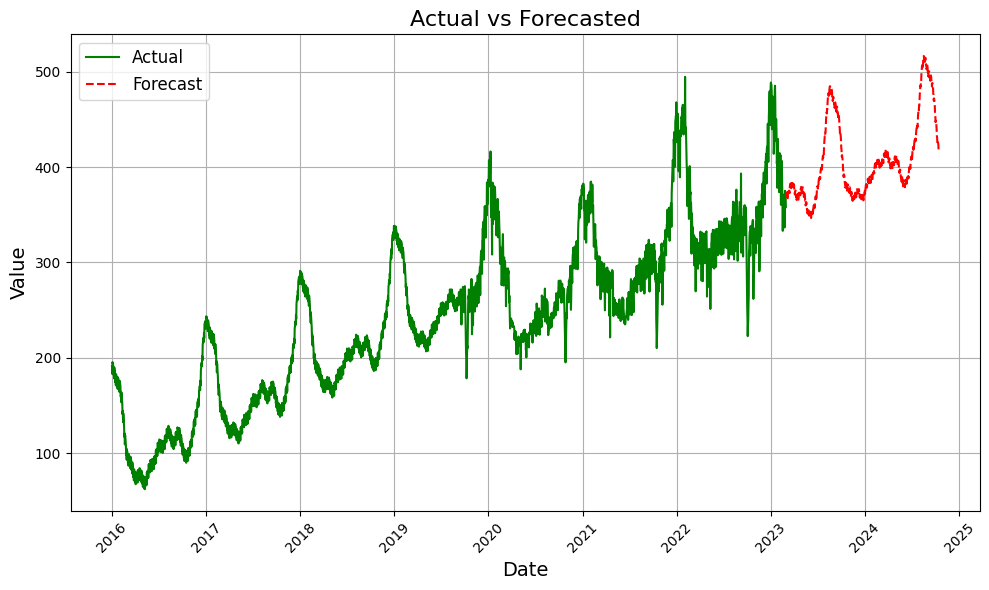

In [25]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'y_forecast' and 'data' are your forecast and actual data respectively

# Flatten y_forecast if it's not already flattened
y_forecast = y_forecast.flatten()

# Generate dates for forecast
dates = pd.date_range(start='2023-03-01', periods=len(y_forecast), freq='D')

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame({'ds': dates, 'y': y_forecast})

# Plot actual and forecasted values
plt.figure(figsize=(10, 6))  # Set figure size

# Plot actual data in green color
plt.plot(data['ds'], data['y'], label='Actual', color='green')

# Plot forecasted data with dashed line in red color
plt.plot(forecast_df['ds'], forecast_df['y'], label='Forecast', linestyle='--', color='red')

# Set labels and title
plt.xlabel('Date', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.title('Actual vs Forecasted', fontsize=16)

# Add grid lines
plt.grid(True)

# Add legend
plt.legend(fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()  # Adjust layout
plt.show()

